In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data =  pd.read_csv("saleshourly.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


# Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

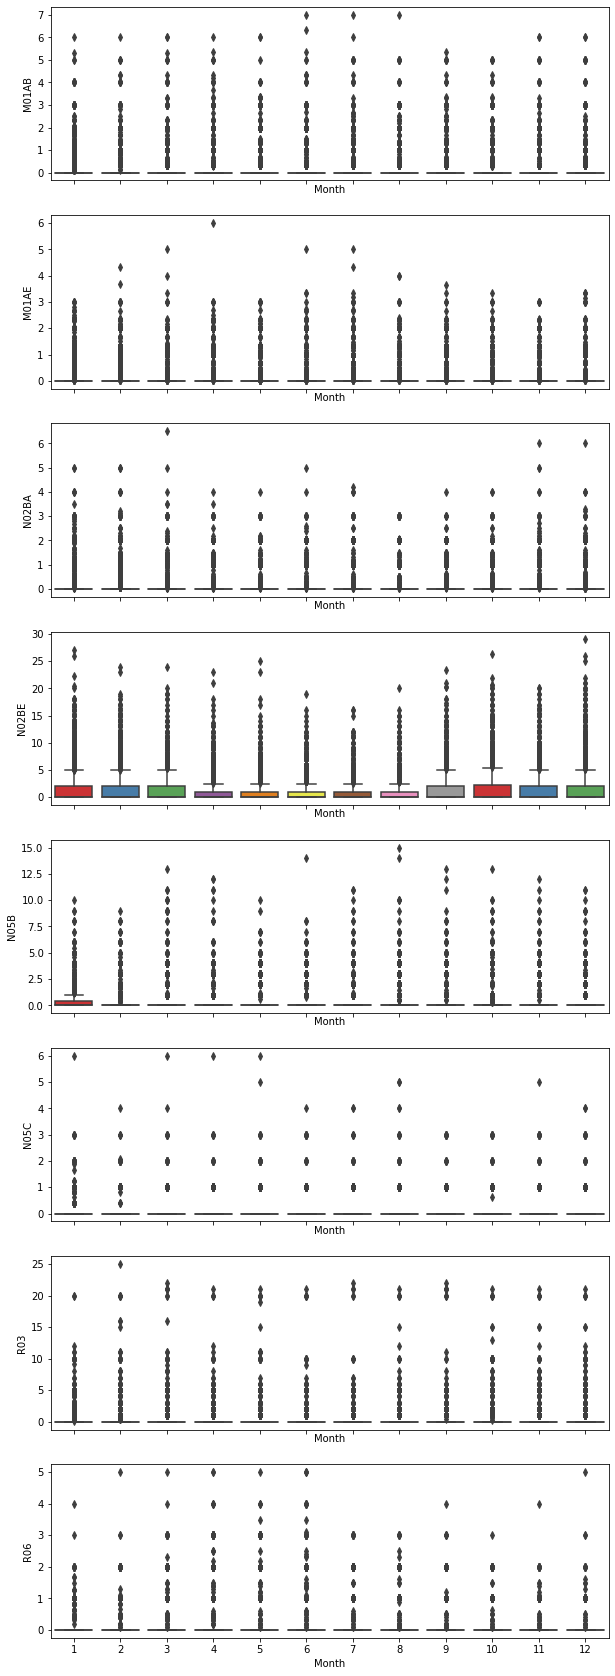

In [ ]:
import seaborn as sns
dfatc_daily = data
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month',palette='Set1' ,y=name, ax=ax)
    

Below, boxplots on a weekly scale are shown, for the purpose of exploring the weakly seasonality. Some weekly seasonality is visible.

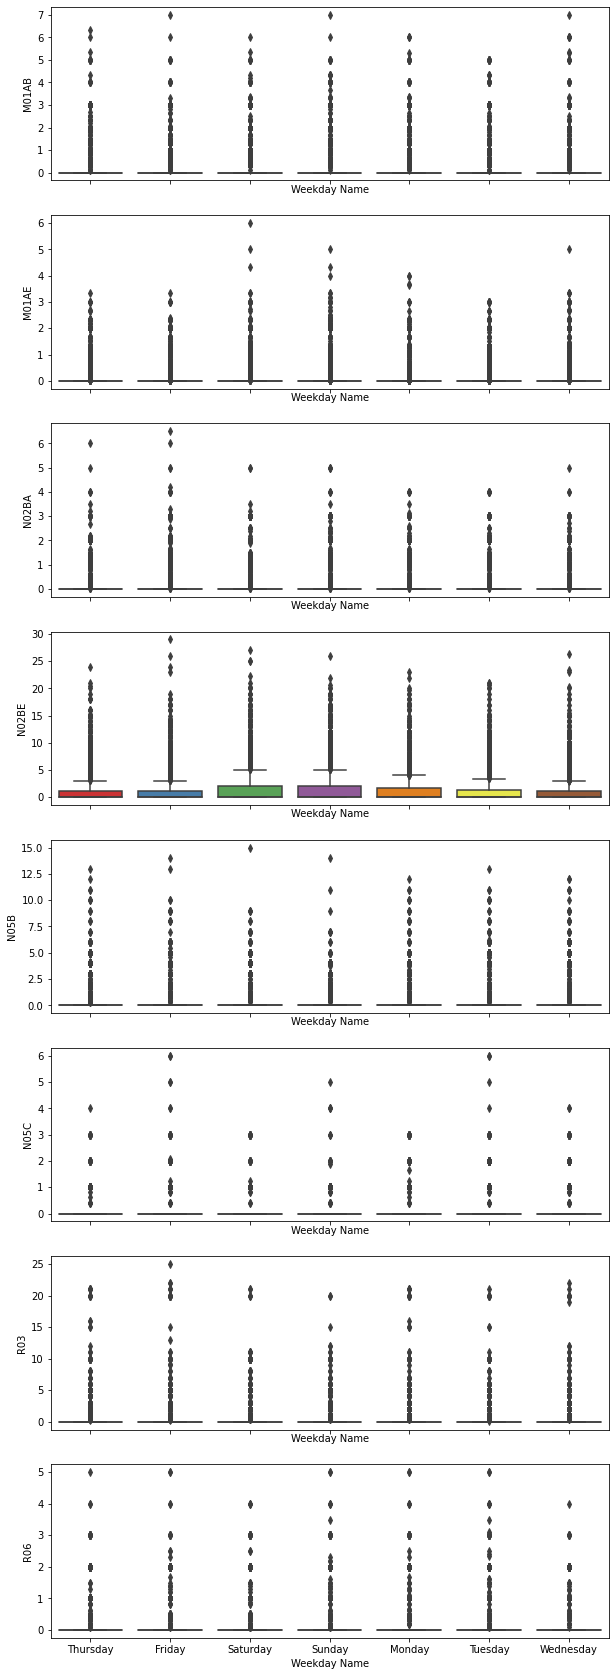

In [ ]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, palette='Set1',ax=ax)

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Rolling window operations are another important transformation for time series data.

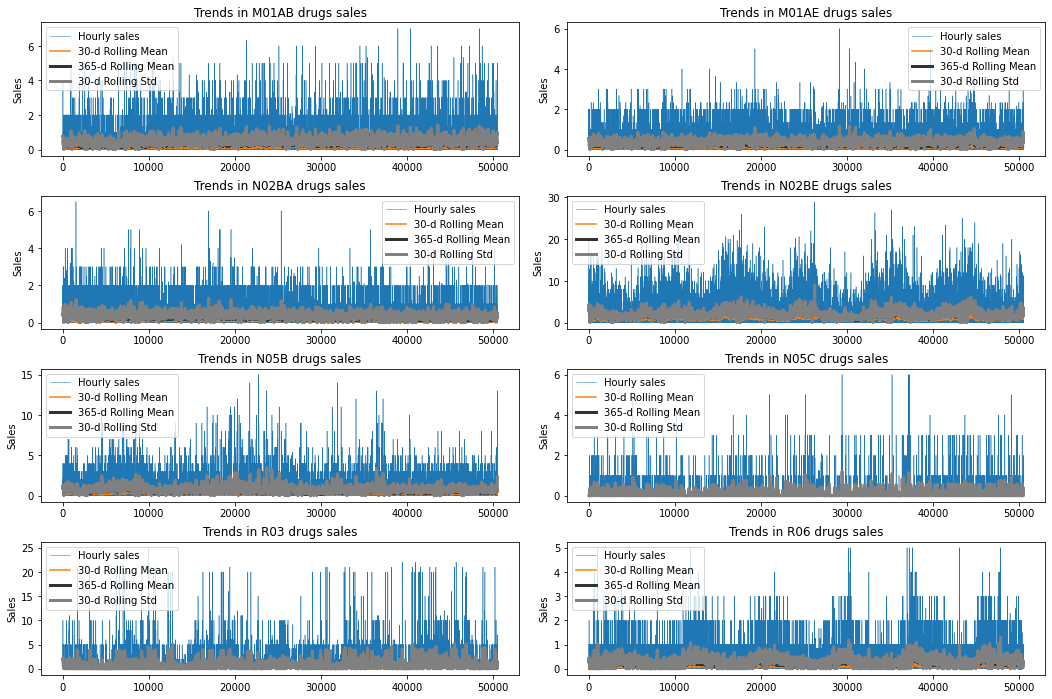

In [ ]:
dfatc_daily=data
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Hourly sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

Image below shows trends for each of the drug categories, represented by the 365-d rolling means for each of those categories.

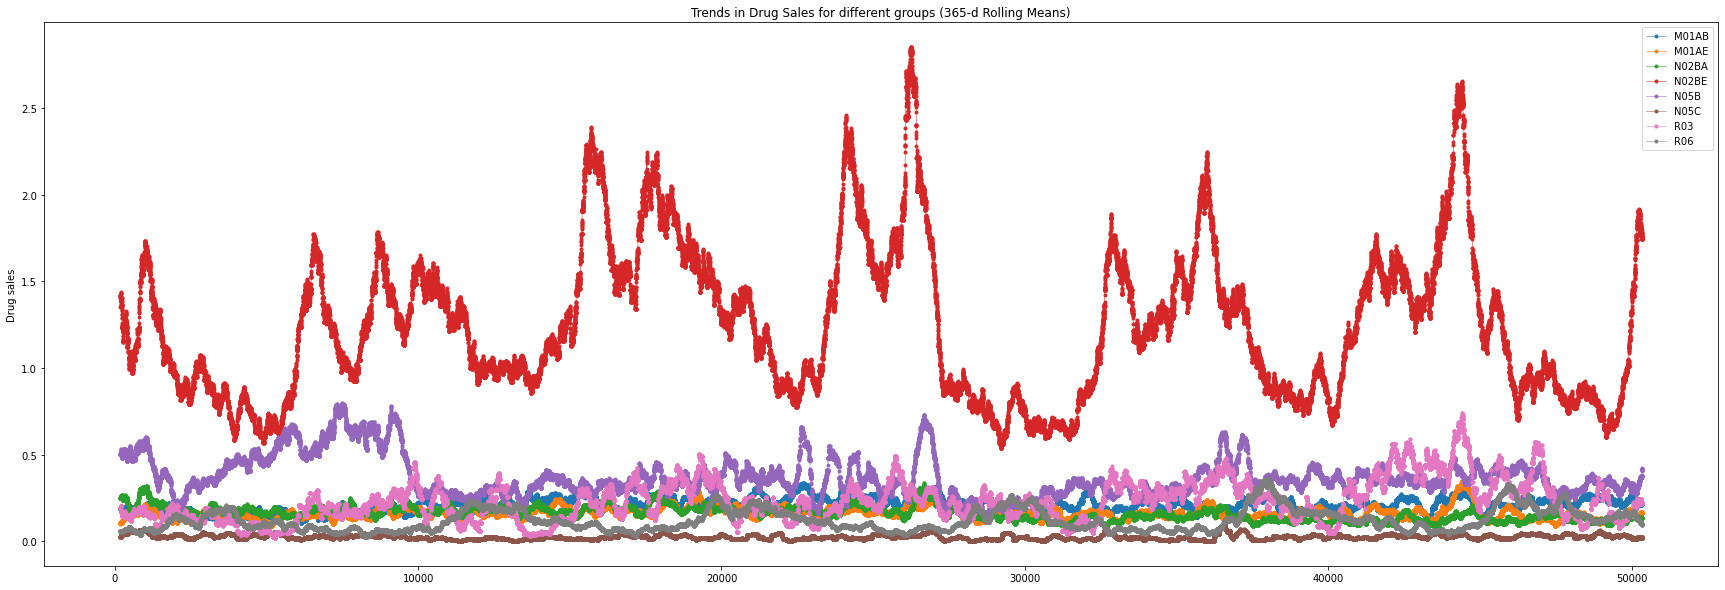

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

Trends and seasonality can be explored in time series decomposition view, based on 30d rolling means.

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. 

In [ ]:
df = data
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:0.3342712924000216, OBSMEAN:0.2099829057717512, PERC:159.18976412459514%
M01AE RESMEAN:0.2555137115823204, OBSMEAN:0.1623888994823098, PERC:157.3467844149996%
N02BA RESMEAN:0.26618345402885113, OBSMEAN:0.1617533478608954, PERC:164.56132596264004%
N02BE RESMEAN:1.4862341913135293, OBSMEAN:1.2462857113380548, PERC:119.25308761807577%
N05B RESMEAN:0.5489321550813502, OBSMEAN:0.3687547048338748, PERC:148.86105801108243%
N05C RESMEAN:0.04989793899211296, OBSMEAN:0.024721837031240097, PERC:201.8375047495812%
R03 RESMEAN:0.4167628878380153, OBSMEAN:0.22992913860271394, PERC:181.2570996310844%
R06 RESMEAN:0.2056009467139425, OBSMEAN:0.12095518026996831, PERC:169.9811006482297%


In [3]:
df = data    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

# Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

In [ ]:
df= data
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -27.619
P-value = 0.000
Critical values :
	1%: -3.958949372811216 - The data is  stationary with 99% confidence
	5%: -3.410576986944579 - The data is  stationary with 95% confidence
	10%: -3.1271012279147996 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -26.427
P-value = 0.000
Critical values :
	1%: -3.958949372811216 - The data is  stationary with 99% confidence
	5%: -3.410576986944579 - The data is  stationary with 95% confidence
	10%: -3.1271012279147996 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -27.253
P-value = 0.000
Critical values :
	1%: -3.958949372811216 - The data is  stationary with 99% confidence
	5%: -3.410576986944579 - The data is  stationary with 95% confidence
	10%: -3.1271012279147996 - The data is  stationary with 90% confidence
ADF test for N02BE
---------------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [ ]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")
df=data
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	

# Regularity analysis

# Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

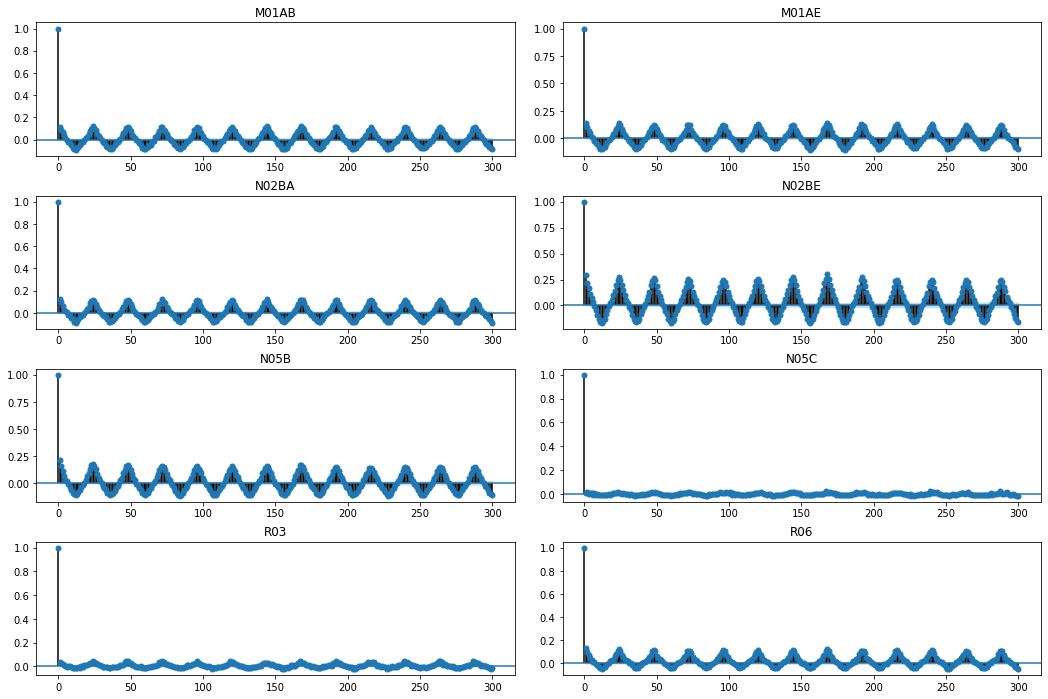

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables.

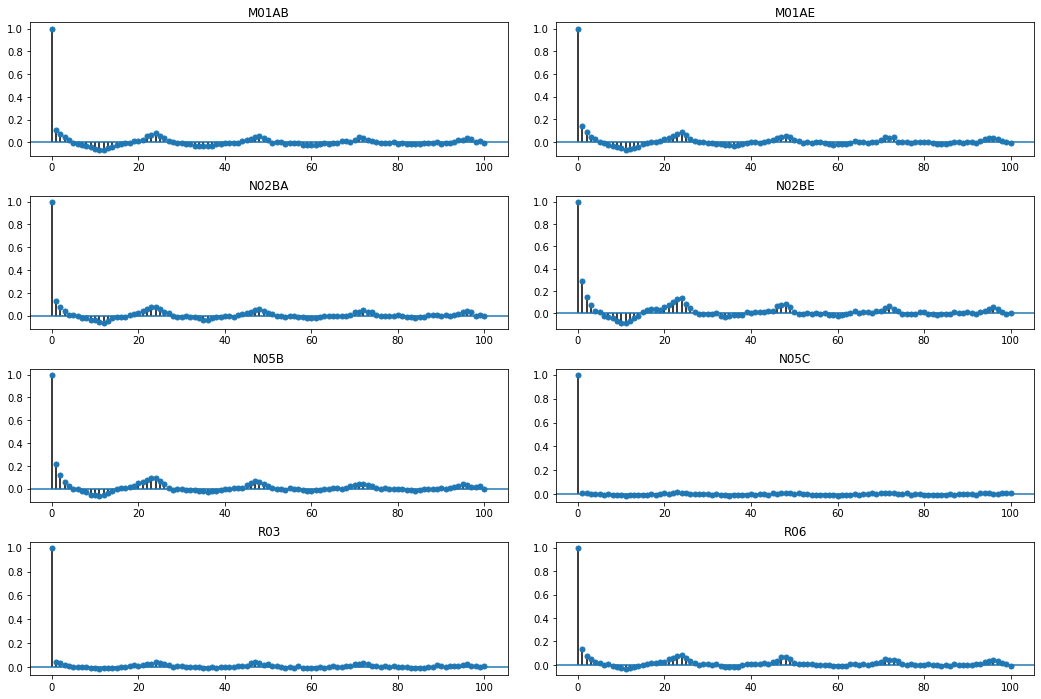

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

# Data distribution analysis

Chart with daily sales for different categories of interest is shown below.

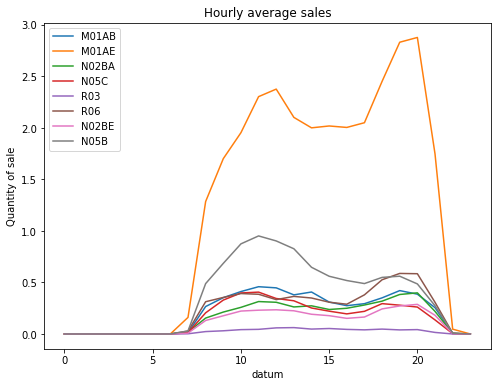

In [ ]:
dfatch= data
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06'].mean()
grp4=dfatch.groupby(dfatch.datum.dt.hour)['N02BE'].mean()
grp5=dfatch.groupby(dfatch.datum.dt.hour)['N05B'].mean()

plt.title('Hourly average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp4.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))
grp5.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06', "N02BE", "N05B"], loc='upper left')

plt.show()

# **Autoregression**

# Import the Libraries

In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 21.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Import the Dataset**

In [ ]:
data =  pd.read_csv("saleshourly.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


# Data Preparation

## Pre-Processing

### Categorical Data

In [ ]:
data.dtypes

datum            object
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
Year              int64
Month             int64
Hour              int64
Weekday Name     object
dtype: object

In [ ]:
data1 = data

### Missing Values

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50532 entries, 0 to 50531
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         50532 non-null  object 
 1   M01AB         50532 non-null  float64
 2   M01AE         50532 non-null  float64
 3   N02BA         50532 non-null  float64
 4   N02BE         50532 non-null  float64
 5   N05B          50532 non-null  float64
 6   N05C          50532 non-null  float64
 7   R03           50532 non-null  float64
 8   R06           50532 non-null  float64
 9   Year          50532 non-null  int64  
 10  Month         50532 non-null  int64  
 11  Hour          50532 non-null  int64  
 12  Weekday Name  50532 non-null  object 
dtypes: float64(8), int64(3), object(2)
memory usage: 5.0+ MB


In [ ]:
data1.isna().sum()

datum           0
M01AB           0
M01AE           0
N02BA           0
N02BE           0
N05B            0
N05C            0
R03             0
R06             0
Year            0
Month           0
Hour            0
Weekday Name    0
dtype: int64

### Outlier Data

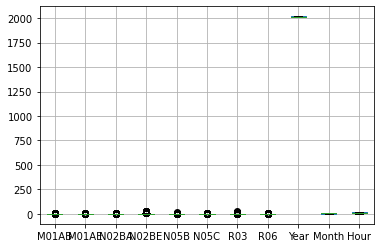

In [ ]:
data1.boxplot()

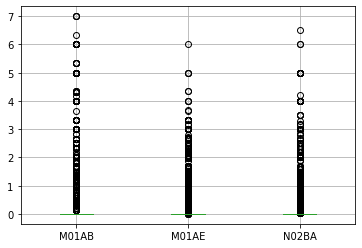

In [ ]:
data1.iloc[:,[1,2,3]].boxplot()

chon outlier ha ro dar dataset haye qabl negah dashtim pas, tasmim be negahdari az onha gerfte shod bejaye hazf anha.

### Duplicated Data

In [ ]:
data1.duplicated().sum()

0

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(50532, 12)

In [ ]:
features = list(data2.columns)
del features[8:]

# **autoregression**

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

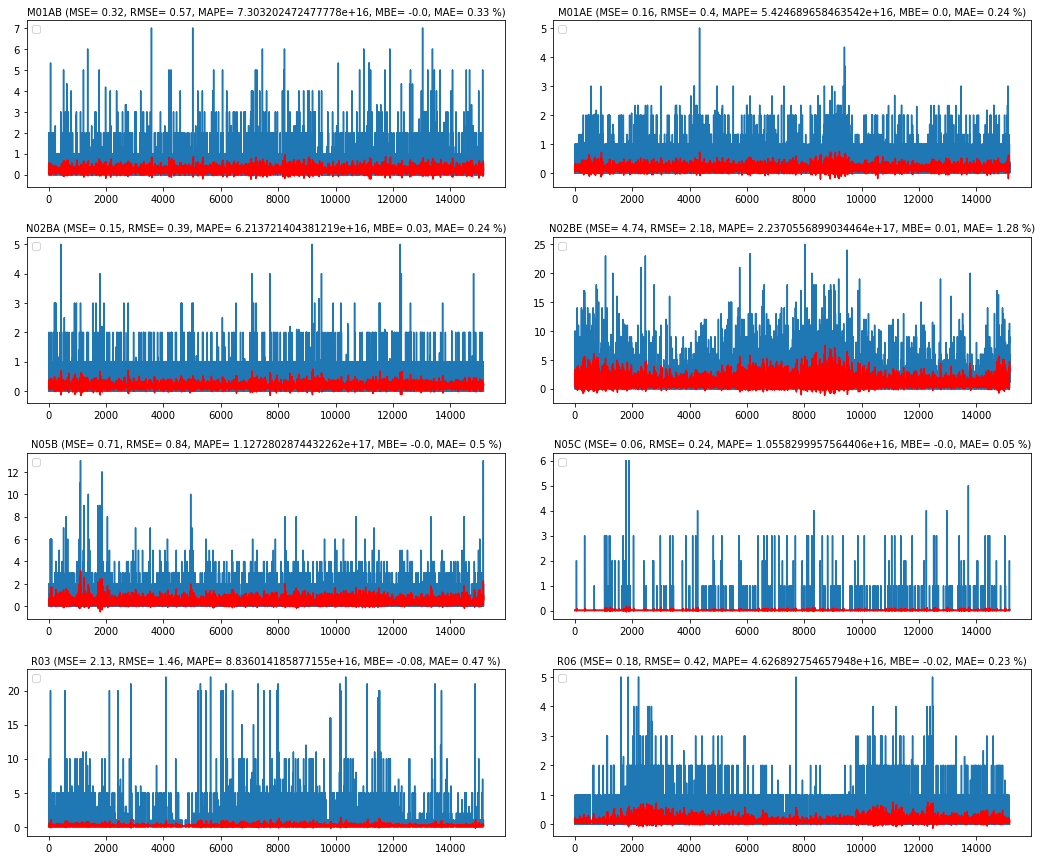

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  train, test = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  train = train[j].values
  test = test[j].values
  
  # train autoregression
  window = 29
  model = AutoReg(train, lags=29)
  model_fit = model.fit()
  coef = model_fit.params
  # walk forward over time steps in test
  history = train[len(train)-window:]
  history = [history[i] for i in range(len(history))]
  predictions = list()
  for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window , length)]
    yhat = coef[0]
    for d in range(window):
      yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
 
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions - test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
mse

[0.32, 0.16, 0.15, 4.74, 0.71, 0.06, 2.13, 0.18]

In [ ]:
mape

[7.303202472477778e+16,
 5.424689658463542e+16,
 6.213721404381219e+16,
 2.2370556899034464e+17,
 1.1272802874432262e+17,
 1.0558299957564406e+16,
 8.836014185877155e+16,
 4.626892754657948e+16]

In [ ]:
rmse

[0.57, 0.4, 0.39, 2.18, 0.84, 0.24, 1.46, 0.42]

In [ ]:
mae

[0.33, 0.24, 0.24, 1.28, 0.5, 0.05, 0.47, 0.23]

In [ ]:
mbe

[-0.0, 0.0, 0.03, 0.01, -0.0, -0.0, -0.08, -0.02]